In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go # 그래프 객체 생성
from plotly.subplots import make_subplots
import datetime
import seaborn as sns 
import scipy.stats
import plotly.express as px
import os 
from scipy import stats
from sklearn import metrics
import statsmodels.formula.api as smf
import scipy.stats as st
import pylab
import csv

os.getcwd()

data1 = pd.read_csv("./ENITT_SOLAR_DATA/ENITT_SOLAR_DATA/B115. 주문진해안주차타워 발전량.csv", encoding="ms949")
data2 = pd.read_csv("./ENITT_SOLAR_DATA/ENITT_SOLAR_DATA/B115. 주문진해안주차타워 환경센서.csv", encoding="ms949")



ent_data_solar = data1.reset_index().drop('index', axis=1)
ent_data_solar

ent_data_weather = data2.reset_index().drop('index', axis=1)


## 외부데이터 불러오기 
def other_loadfile(a, b, c): ## 임의로 수정 필요 
    other_data_dummy1 = pd.read_csv(a, encoding="ms949")
    other_data_dummy2 = pd.read_csv(b, encoding="ms949")
    other_data_dummy3 = pd.read_csv(c, encoding="ms949")

    return other_data_dummy1, other_data_dummy2, other_data_dummy3

other_data_dummy1, other_data_dummy2, other_data_dummy3 = other_loadfile(
    "./ENITT_SOLAR_DATA/re_allweather/allweather2018.csv",
    "./ENITT_SOLAR_DATA/re_allweather/allweather2019.csv",
    "./ENITT_SOLAR_DATA/re_allweather/allweather2020.csv")


other_data_dummyall = other_data_dummy1.merge(other_data_dummy2, how="outer").merge(other_data_dummy3, how="outer")
other_data_weather = other_data_dummyall[other_data_dummyall["지점명"] == "강릉"]
other_data_weather["지점명"].unique()



# print()
ent_data_solar1 = ent_data_solar[ent_data_solar["pow_id"] == 1]
# ent_data_weather

ent_data_solar["pow_id"].unique()



array([1, 2], dtype=int64)

In [3]:
## DELETE COLUMN AND EDIT COLUMN

## '지점', '지점명', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)','일조(hr)', '일사(MJ/m2)', '적설(cm)', '전운량(10분위)', '10cm 지중온도(°C)'
#=>

## '기온', '강수량', '풍속', '풍향', '습도', '일조', '일사', '전운량', '지면온도'
reset_other_weather = other_data_weather.set_index("일시")
reset_other_weather_need = reset_other_weather[['기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)','일조(hr)', '일사(MJ/m2)', '적설(cm)', '전운량(10분위)', '10cm 지중온도(°C)']]
reset_other_weather_need.columns = ['기온', '강수량', '풍속', '풍향', '습도', '일조', '일사', '적설', '전운량', '지중온도']
reset_other_weather_need.fillna(0, inplace=True)
reset_other_weather_need


## 기업 solar weather EDA -> 필요
ent_data_weather.columns 

ent_data_weather["env_levelsolar"].describe()
ent_data_weather["env_slopesolar"].describe()


## 기업 날씨 데이터 1시간 별로 groupby , ( slopesolar, levelsolar => sum) , ( modtemp, airtemp => mean )
def groupby_weather():
    ## time 구분
    dummy_time_list = []
    for i in ent_data_weather["env_time"]:
        dummy_time_list.append(i[:2])

    ent_data_weather["dummy_time"] = dummy_time_list
    dummy_groupbyall = ent_data_weather.groupby(["env_date", "dummy_time"]).mean()
    ent_data_weather_groupby = dummy_groupbyall.reset_index() ## 그룹화된 인덱스 풀기 

    ### 발전량이 거의 없는 데이터 삭제 ( 9~ 19 까지만 살린다)
    drop_data = ent_data_weather_groupby.isin({"dummy_time" : ["00", "01", "02", "03", "04", "05", "06", "07","08","18", "19", "20", "21", "22", "23"]})
    ent_data_weather_sort = ent_data_weather_groupby[~drop_data].dropna()
    # print(ent_data_weather_sort)
    ent_data_weather_sort.drop("env_index", axis=1, inplace=True)

    return ent_data_weather_sort




def groupby_solar_reset():
    ## 필요한 컬럼만 가져오기
    ent_data_need = ent_data_solar1[["pow_date", "pow_time", "pow_dcv", "pow_dca"]]

    ## time 구분
    dummy_time_list = []
    for i in ent_data_need["pow_time"]:
        dummy_time_list.append(i[:2])
    ent_data_need["dummy_time"] = dummy_time_list

    ent_data_need["watt"] = ent_data_need["pow_dcv"] * ent_data_need["pow_dca"]

    ## RESET 발전량 :: 직류 전압 X 직류 전류 : 발전량 ,, GROUPBY해서 직류X전류 의 평균량으로 구한다
    ent_data_perhour = ent_data_need.groupby(["pow_date", "dummy_time"]).mean()
    ent_data_perhour = ent_data_perhour.reset_index()


    drop_data = ent_data_perhour.isin({"dummy_time" : ["00", "01", "02", "03", "04", "05", "06", "07","08","18", "19", "20", "21", "22", "23"]})
    ent_data_perhour_sort = ent_data_perhour[~drop_data].dropna()

    return ent_data_perhour_sort

### weather, solar join
def join_weather_solar(a, b):
    sub_index1 = a["env_date"] + " " + a["dummy_time"] + ":00"
    a.index = sub_index1

    sub_index2 = b["pow_date"] + " " + b["dummy_time"] + ":00"
    b.index = sub_index2

    joinset = a.join(b[["pow_dcv", "pow_dca", "watt" ]])
    ent_data_solar_weather = joinset.dropna()


    return ent_data_solar_weather

ent_data_weather_sort = groupby_weather()
ent_data_perhour_sort = groupby_solar_reset()
ent_data_solar_weather = join_weather_solar(ent_data_weather_sort, ent_data_perhour_sort)
ent_data_solar_weather

# ent_data_solar_weather[ent_data_solar_weather["env_date"]]
atype = ent_data_solar_weather.iloc[:1100]
btype = ent_data_solar_weather.iloc[1800:]

ent_data_solar_weather = pd.concat([atype, btype])
# print(type(a[1]))
ent_data_solar_weather


,env_date,dummy_time,env_slopesolar,env_levelsolar,env_modtemp,env_airtemp,pow_dcv,pow_dca,watt
2020-04-08 09:00,2020-04-08,09,154.614286,152.600000,8.548571,8.002857,632.171429,6.940000,4441.110000
2020-04-08 10:00,2020-04-08,10,561.043478,393.550725,18.626087,10.144928,626.536232,25.794203,16054.202899
2020-04-08 11:00,2020-04-08,11,812.328571,879.871429,25.018571,11.657143,620.357143,36.870000,22870.128571
2020-04-08 12:00,2020-04-08,12,474.897059,515.264706,19.039706,11.083824,622.536232,22.205797,13721.611594
2020-04-08 13:00,2020-04-08,13,842.657143,937.414286,24.085714,12.055714,622.571429,38.441429,23922.360000
...,...,...,...,...,...,...,...,...,...
2020-08-07 15:00,2020-08-07,15,101.916667,91.000000,28.516667,25.991667,588.500000,4.150000,2448.583333
2020-08-07 16:00,2020-08-07,16,54.153846,48.923077,26.861538,25.484615,576.461538,2.438462,1409.038462
2020-08-07 17:00,2020-08-07,17,23.083333,21.833333,24.808333,24.533333,557.583333,1.275000,711.983333
2020-08-08 09:00,2020-08-08,09,77.416667,70.333333,23.216667,22.208333,593.583333,3.416667,2035.233333


In [5]:
## 기업, 공공 join

join_ent_other = ent_data_solar_weather.join(reset_other_weather_need)
join_ent_other["일사"].fillna(0, inplace=True)
# join_ent_other
join_ent_other["match_solar"] = join_ent_other["일사"] * 1000000 / 3600
join_ent_other_set = join_ent_other.drop(["env_date", "dummy_time"], axis=1)





1.806889933885403
-1.496264217325759


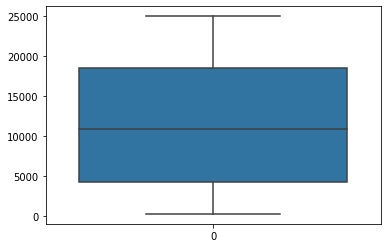

In [7]:
## 이상치 제거

# sns.boxplot(data = join_ent_other_set["watt"])


import pandas as pd
from scipy import stats

# deleteoutlier = stats.zscore(join_ent_other_set["watt"])
# deleteoutlier
deleteoutlier = stats.zscore(join_ent_other_set["watt"])
join_ent_other_set["z_score"] = deleteoutlier

join_ent_other_del = join_ent_other_set.loc[join_ent_other_set['z_score'].abs()<=3]
join_ent_other_del.describe()
sns.boxplot(data = join_ent_other_del["watt"])
# df.loc[df['z_score'].abs()<=3]
print(join_ent_other_del['z_score'].max())
print(join_ent_other_del['z_score'].min())
## csv 저장
join_ent_other_del.to_csv('zumun1_join.csv', encoding='utf-8')

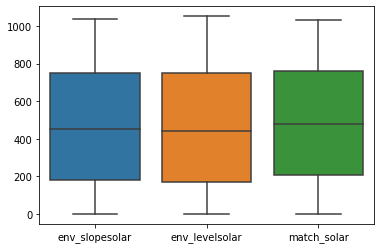

In [8]:
sns.boxplot(data = join_ent_other_del[["env_slopesolar", "env_levelsolar", "match_solar"]])